# This is a notebook for querying the CMEMS BGC instance for the 1.0.0 Beacon release.
* You can run each cell individually by pressing "shift + enter".
* For more information, questions, bugs, please contact us on Slack:
    + https://join.slack.com/t/beacontechnic-wwa5548/shared_invite/zt-2dp1vv56r-tj_KFac0sAKNuAgUKPPDRg.

#### In order to get access to the Beacon endpoint, you need to fill in your unique personal token between the " " in the cell below.

In [103]:
Token = ""

#### Install the following packages, if you have not already installed them in your environment:
* pip install requests
* pip install xarray
* pip install ipywidgets
* pip install cartopy
* pip install h5netcdf
* pip install netcdf4
* pip install scipy
* pip install packaging

#### Import the required packages

In [104]:
import requests
import json
import xarray as xr
import datetime
import pandas as pd
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

#### Retrieve the available columns from the CMEMS BGC endpoint
Swagger page here: https://beacon-cmems.maris.nl/swagger/ 

In [105]:
responseinfo = requests.get("https://beacon-cmems.maris.nl/api/query/available-columns",
                            headers={"Authorization": f"Bearer {Token}"})


params = responseinfo.json()

#### Below you can search through the available columns by entering text between the brackets of search_columns(" ").

In [106]:
def search_columns(search_term):
    search_term = search_term.lower()
    matches = [col for col in params if search_term in col.lower()]

    if matches:
        print("Matching columns:")
        for match in matches:
            print(match)
    else:
        print("No matching columns found.")


search_columns("TEMP")  # Enter your search term here

Matching columns:
POTENTIAL_TEMP
POTENTIAL_TEMP._FillValue
POTENTIAL_TEMP.ancillary_variables
POTENTIAL_TEMP.coordinates
POTENTIAL_TEMP.data_mode
POTENTIAL_TEMP.long_name
POTENTIAL_TEMP.standard_name
POTENTIAL_TEMP.units
POTENTIAL_TEMP_QC
POTENTIAL_TEMP_QC._FillValue
POTENTIAL_TEMP_QC.coordinates
POTENTIAL_TEMP_QC.flag_meanings
POTENTIAL_TEMP_QC.long_name
POTENTIAL_TEMP_QC.valid_max
POTENTIAL_TEMP_QC.valid_min
TEMP
TEMP._FillValue
TEMP.ancillary_variables
TEMP.coordinates
TEMP.data_mode
TEMP.instrument
TEMP.long_name
TEMP.sensor_id
TEMP.sensor_serial_number
TEMP.standard_name
TEMP.units
TEMP.valid_max
TEMP.valid_min
TEMP_ADJUSTED
TEMP_ADJUSTED._FillValue
TEMP_ADJUSTED.ancillary_variables
TEMP_ADJUSTED.coordinates
TEMP_ADJUSTED.data_mode
TEMP_ADJUSTED.long_name
TEMP_ADJUSTED.standard_name
TEMP_ADJUSTED.units
TEMP_ADJUSTED_DM
TEMP_ADJUSTED_DM._FillValue
TEMP_ADJUSTED_DM.coordinates
TEMP_ADJUSTED_DM.flag_meanings
TEMP_ADJUSTED_DM.flag_values
TEMP_ADJUSTED_DM.long_name
TEMP_ADJUSTED_ERROR


#### You can define here your input parameters 

In [107]:
parameter = "TEMP"  # column name
mindate = "2010-01-01"  # yyyy-mm-dd
maxdate = "2010-03-01"  # yyyy-mm-dd
minlon = -20
maxlon = 30
minlat = 30
maxlat = 70
mindepth = 0
maxdepth = 10

#### This will create the query body based on your input parameters, you can add other "query_parameters" and "filters" to suit your needs. 
* For more query examples and explanations, you can take a look at https://github.com/maris-development/beacon-blue-cloud.  

In [108]:
def query(parameter, mindate, maxdate, minlon, maxlon, minlat, maxlat, mindepth, maxdepth):
    body = {
        "query_parameters": [
            {
                "column_name": parameter,
                "alias": parameter,
                "skip_fill_values": True
            },
            {
                "column_name": f"{parameter}.units",
                "alias": "Unit"
            },
            {
                "column_name": "cf_datetime",
                "alias": "datetime"
            },
            {
                "column_name": "DEPH",
                "alias": "DEPTH"
            },
            {
                "column_name": "LONGITUDE",
                "alias": "LONGITUDE"
            },
            {
                "column_name": "LATITUDE",
                "alias": "LATITUDE"
            }
        ],
        "filters": [
            {
                "for_query_parameter": "datetime",
                "min": f"{mindate}T00:00:00",
                "max": f"{maxdate}T00:00:00",
                "cast": "timestamp"
            },
            {
                "for_query_parameter": "DEPTH",
                "min": mindepth,
                "max": maxdepth
            },
            {
                "for_query_parameter": "LONGITUDE",
                "min": minlon,
                "max": maxlon
            },
            {
                "for_query_parameter": "LATITUDE",
                "min": minlat,
                "max": maxlat
            }
        ],
        "output": {
            "format": "netcdf"
        }}
    return body


query_body = query(parameter, mindate, maxdate, minlon,
                   maxlon, minlat, maxlat, mindepth, maxdepth)

#### This is the post request that is sent to Beacon with the above specified body.

In [109]:
response = requests.post("https://beacon-cmems.maris.nl/api/query", json.dumps(query_body), headers={
    "Authorization": f"Bearer {Token}",
    "Content-type": "application/json"
})

if response.status_code == 204:
    print("No data has been found for your query, please update your input fields above and run the notebook again.")
elif response.status_code != 200:
    print(response.text)

In [110]:
regionname = f"[{minlat},{minlon}],[{maxlat},{maxlon}]"

if not os.path.exists("./Beacon_V1.0.0_Output"):
    os.makedirs("Beacon_V1.0.0_Output")

open(
    f"./Beacon_V1.0.0_Output/CMEMS_BGC_{parameter}_{regionname}_{mindate}-{maxdate}_[{mindepth}-{maxdepth}m].nc", "wb").write(response.content)
df = xr.open_dataset(
    f"./Beacon_V1.0.0_Output/CMEMS_BGC_{parameter}_{regionname}_{mindate}-{maxdate}_[{mindepth}-{maxdepth}m].nc").to_dataframe()
df = df.assign(datetime=pd.to_datetime(
    df["datetime"])).set_index("datetime").sort_index()
df

,TEMP,Unit,DEPTH,LONGITUDE,LATITUDE,dataset_id
datetime,,,,,,
2010-01-04,1.52,degrees_C,0.0,9.7550,58.990002,1372.0
2010-01-04,3.10,degrees_C,1.0,4.0142,51.436199,694.0
2010-01-04,3.40,degrees_C,1.0,3.8255,51.346500,694.0
2010-01-04,3.50,degrees_C,1.0,3.5657,51.411999,694.0
2010-01-04,-0.48,degrees_C,0.0,9.6200,58.891998,1372.0
...,...,...,...,...,...,...
2010-03-01,3.70,degrees_C,1.0,4.0142,51.436199,694.0
2010-03-01,3.00,degrees_C,1.0,4.7500,52.982498,694.0
2010-03-01,3.50,degrees_C,1.0,3.8255,51.346500,694.0


#### Plotting of results.

C:\Users\robin\AppData\Local\Temp\ipykernel_16772\16950125.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cbar.set_label(f"{parameter} [{df['Unit'][0]}]")


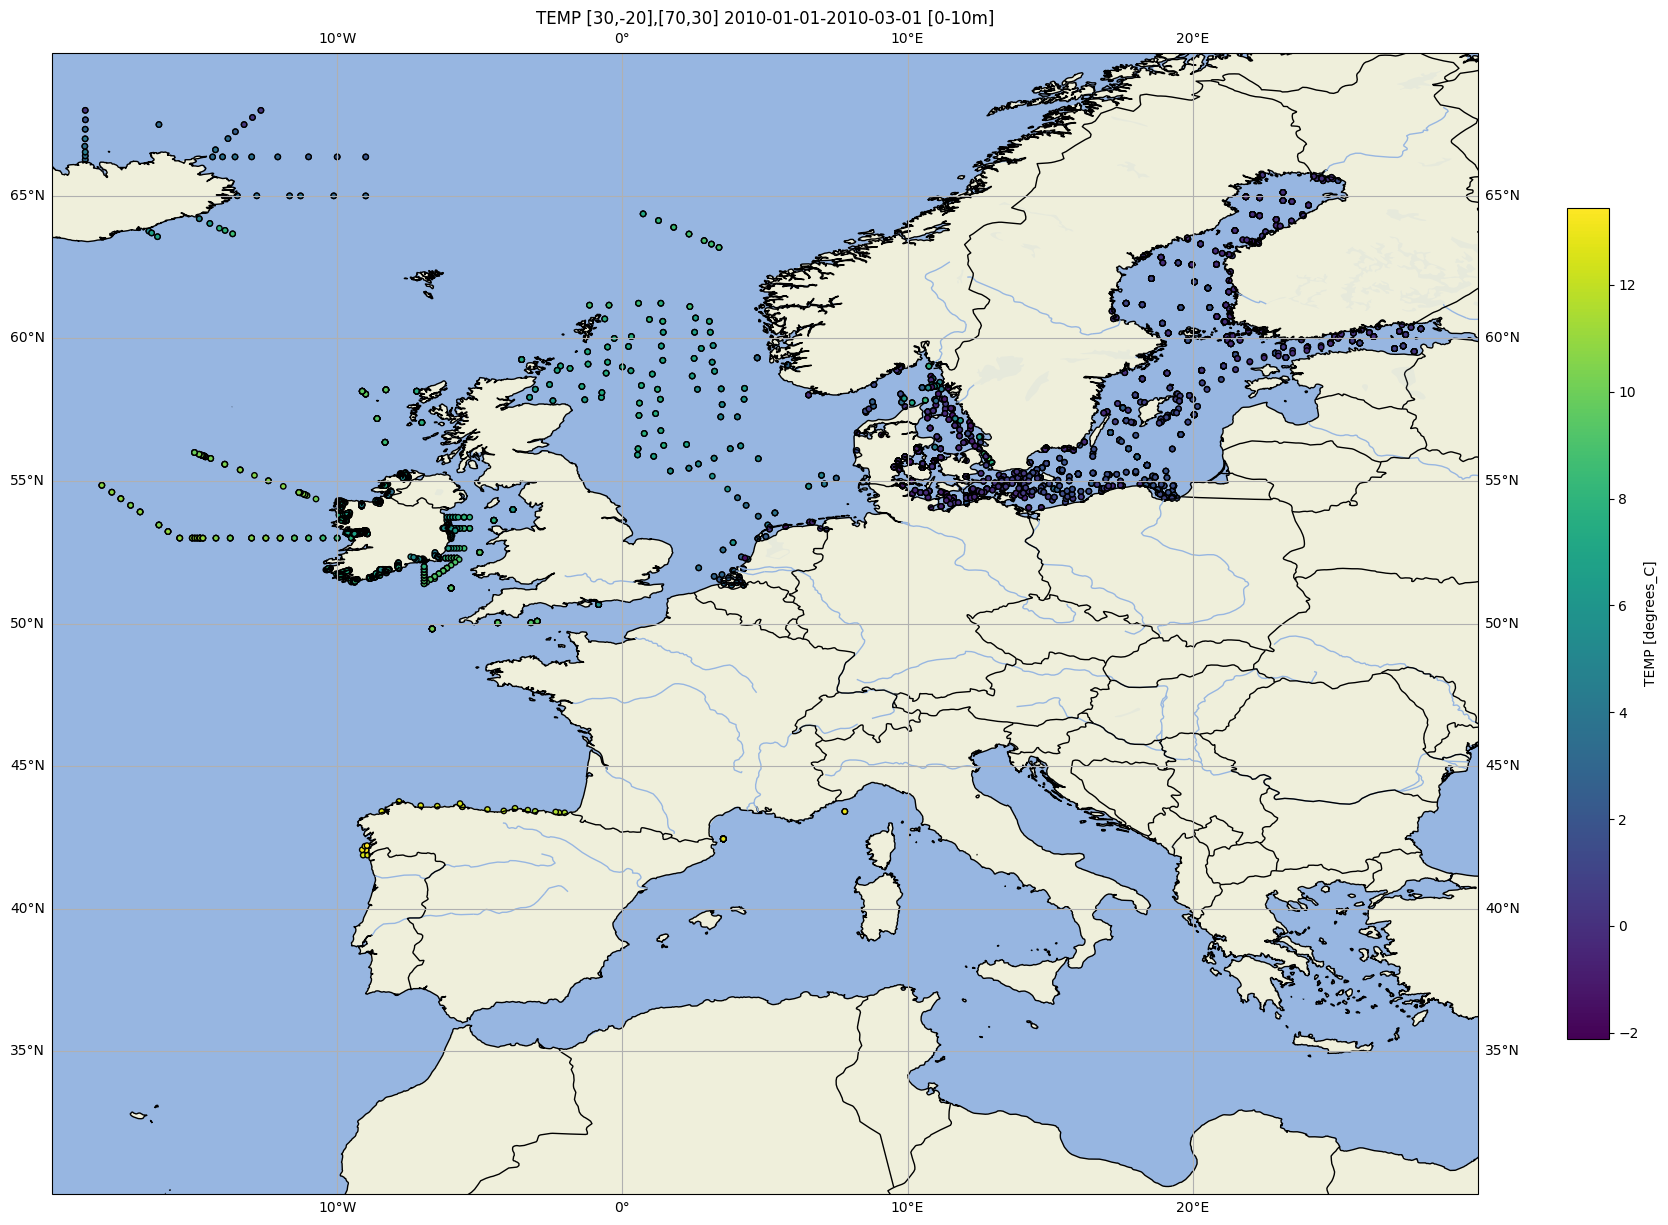

In [111]:
fig = plt.figure(figsize=(23, 18))
ax = plt.axes(projection=ccrs.PlateCarree())

# (west, east, south, north)
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())

ax.coastlines(resolution="10m")
ax.gridlines(draw_labels=True)

sc = ax.scatter(df["LONGITUDE"], df["LATITUDE"], c=df[parameter],
                cmap="viridis", s=15, edgecolor="black", transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES, alpha=0.1)

cbar = plt.colorbar(sc, ax=ax, orientation="vertical",
                    shrink=0.6, label="Value Set 1")

cbar.set_label(f"{parameter} [{df['Unit'][0]}]")

plt.title(
    f"{parameter} {regionname} {mindate}-{maxdate} [{mindepth}-{maxdepth}m]")

plt.show()